<a href="https://colab.research.google.com/github/komisarzGiT/gai/blob/main/UG_ML02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Marcin Byra  
Class: 2526-1MAO2  
Student ID: 25258161

Assignment 2  
Classification of Seizure using Machine Learning Classifiers and EEG Data

The objective is to
Cardiac Health Records

In [41]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

In [42]:
#Cardiac Health Records
cardiac_data = 'https://raw.githubusercontent.com/komisarzGiT/gai/refs/heads/main/GU_ML01/Assignment2/Modified_Heart_failure_data.csv'

df_cardiac_data = pd.read_csv(cardiac_data)

#no split into train and test sets
#there are no know labels and objective is not prediction but categorization

#check data types
print(f"Data types \n{df_cardiac_data.dtypes}")

Data types 
age                         float64
anaemia                     float64
creatinine_phosphokinase    float64
diabetes                    float64
ejection_fraction           float64
high_blood_pressure         float64
platelets                   float64
serum_creatinine            float64
serum_sodium                float64
sex                         float64
smoking                     float64
time                        float64
patient_id                    int64
dtype: object


In [43]:
cardiac_rows, cardiac_columns = df_cardiac_data.shape
print(f"Cardiac health data set has {cardiac_rows} observations and {cardiac_columns} variables. Sample data:")
display(df_cardiac_data.head(3))

Cardiac health data set has 299 observations and 13 variables. Sample data:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,patient_id
0,75.0,0.0,582.0,0.0,20.0,1.0,265000.00,1.9,130.0,1.0,0.0,4.0,0
1,55.0,0.0,7861.0,0.0,38.0,0.0,263358.03,1.1,136.0,1.0,0.0,6.0,1
2,65.0,NaN,146.0,0.0,20.0,0.0,162000.00,1.3,129.0,1.0,NaN,7.0,2


In [44]:
# need to fill the gaps; using all available data ensures the discovered
# clusters are the most representative and stable for the
# entire population being studied.

missing_values = df_cardiac_data.isnull().sum()
print("Missing Values\n", missing_values)

Missing Values
 age                         29
anaemia                     29
creatinine_phosphokinase    29
diabetes                    29
ejection_fraction           29
high_blood_pressure         29
platelets                   29
serum_creatinine            29
serum_sodium                29
sex                         29
smoking                     29
time                        29
patient_id                   0
dtype: int64


In [45]:
#To fill missing values, distinguish between categorical binary and continous variables.
#Visual data inspection as well as count of valeus caa help here

unique_counts = df_cardiac_data.nunique()
print(unique_counts)

age                          47
anaemia                       2
creatinine_phosphokinase    193
diabetes                      2
ejection_fraction            16
high_blood_pressure           2
platelets                   161
serum_creatinine             37
serum_sodium                 23
sex                           2
smoking                       2
time                        141
patient_id                  299
dtype: int64


In [46]:
# binary (mode); keeps data binary
binary_cols = [ 'anaemia', 'diabetes', 'high_blood_pressure',
    'sex', 'smoking' ]

# continuous (median); median is robust to outliers
continuous_cols = [ 'age', 'creatinine_phosphokinase', 'ejection_fraction',
    'platelets', 'serum_creatinine', 'serum_sodium', 'time' ]

from sklearn.impute import SimpleImputer

# remove patient ID; not relevant for clustering
df_cardiac_fill = df_cardiac_data.drop('patient_id', axis=1)

imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
df_cardiac_fill[continuous_cols] = imputer_median.fit_transform(df_cardiac_fill[continuous_cols])

imputer_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_cardiac_fill[binary_cols] = imputer_mode.fit_transform(df_cardiac_fill[binary_cols])

# covert binary imputation to integer
for col in binary_cols:
    df_cardiac_fill[col] = df_cardiac_fill[col].astype(int)

# Check for remaining missing values to confirm imputation success
print(df_cardiac_fill.isnull().sum())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64


In [98]:
# scaling assures that every feature contributes equally
# to the distance calculation, regardless of its range/magnitude

scaler = StandardScaler()
X_cardiac_scaled = scaler.fit_transform(df_cardiac_fill) #X since it returns np.array


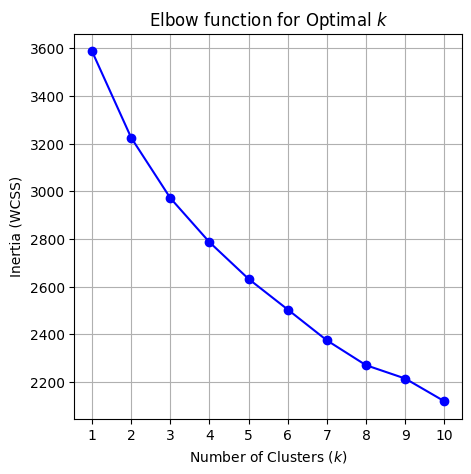

In [100]:
#  Elbow funciton to determine optimum number of clustering
inertia = []
K_range = range(1, 11) #10 clusters is likely too much for risk categories, running it for compelteness

for k in K_range:
    # use k-means++ for probabilistic centroid placement
    # repat 10 times, take lowest inertia for each number of centroids
    kmeans_elbow = KMeans(n_clusters=k, random_state=13, init='k-means++', n_init=10)
    kmeans_elbow.fit(X_cardiac_scaled)
    inertia.append(kmeans_elbow.inertia_)


# elbow function chart
plt.figure(figsize=(5, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-', color='blue')
plt.title('Elbow function for Optimal $k$')
plt.xlabel('Number of Clusters ($k$)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [101]:
# df for inertia
elbow_data = pd.DataFrame({
    'Number of Clusters (k)': K_range,
    'Inertia': inertia
})

# Calculate the decrease in inertia from the previous k
elbow_data['Inertia Decrease'] = elbow_data['Inertia'].diff().abs().round(0)

print("Elbow Function Data (Inertia and Decrease):")
display(elbow_data)

Elbow Function Data (Inertia and Decrease):


,Number of Clusters (k),Inertia,Inertia Decrease
0,1,3588.000000,NaN
1,2,3225.231266,363.0
2,3,2971.941516,253.0
3,4,2786.672195,185.0
4,5,2632.410376,154.0
5,6,2503.989754,128.0
6,7,2374.595219,129.0
7,8,2270.330850,104.0
8,9,2214.441252,56.0
9,10,2119.145729,95.0


In [105]:
#elbow suggest either 3 or 5. going with 3.
k_clusters = 3

# use prefilled data pre-standardization to store clustering result
df_cardiac_scaled = df_cardiac_fill.copy()

# K-Means
kmeans = KMeans(n_clusters=k_clusters, random_state=13, n_init=10)
y_kmeans = kmeans.fit_predict(X_cardiac_scaled)
df_cardiac_scaled['KMeans_Cluster'] = y_kmeans #append clustering result to data poinpoints

# Hierarchical (agglomerative)

agglo = AgglomerativeClustering(n_clusters=k_clusters)
y_agglo = agglo.fit_predict(X_cardiac_scaled)
df_cardiac_scaled['Agglo_Cluster'] = y_agglo #append clustering result to data poinpoints

print(df_cardiac_scaled)

      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                     582.0         0               20.0   
1    55.0        0                    7861.0         0               38.0   
2    65.0        0                     146.0         0               20.0   
3    50.0        1                     111.0         0               20.0   
4    65.0        1                     160.0         1               20.0   
..    ...      ...                       ...       ...                ...   
294  62.0        0                      61.0         1               38.0   
295  55.0        0                    1820.0         0               38.0   
296  45.0        0                    2060.0         1               60.0   
297  45.0        0                     250.0         0               38.0   
298  50.0        0                     196.0         0               45.0   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \

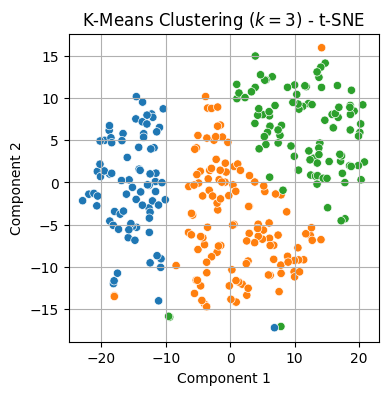

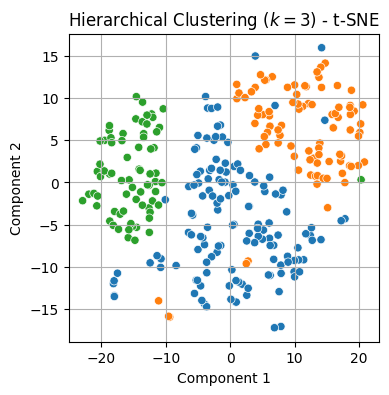

In [106]:
#  t-SNE for graphs
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(X_cardiac_scaled)
tsne_df = pd.DataFrame(data = tsne_components, columns = ['Component 1', 'Component 2'])
tsne_df['KMeans_Cluster'] = df_cardiac_scaled['KMeans_Cluster']
tsne_df['Agglo_Cluster'] = df_cardiac_scaled['Agglo_Cluster']


#chart
def plot_clusters_tsne(df_tsne, cluster_col, title):
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x='Component 1',
        y='Component 2',
        hue=cluster_col,
        data=df_tsne,
        palette = 'tab10',
        legend = False, #legend not needed since tere are no labels. colors are sufficent
    )
    plt.title(f'{title}')
    # plt.xlabel('Component 1')
    # plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# K-Means Plot
plot_clusters_tsne(
    tsne_df,
    'KMeans_Cluster',
    'K-Means Clustering ($k=3$) - t-SNE'
)

# Hierarchical Plot
plot_clusters_tsne(
    tsne_df,
    'Agglo_Cluster',
    'Hierarchical Clustering ($k=3$) - t-SNE'
)

In [107]:
#evaluation

# silhouette score (how similar an object is to its own cluster vs. other clusters)
silhouette_kmeans = silhouette_score(X_cardiac_scaled, y_kmeans).round(2)
silhouette_agglo = silhouette_score(X_cardiac_scaled, y_agglo).round(2)

# davies-bouldin index (average similarity ratio of each cluster with its most similar cluster)
dbi_kmeans = davies_bouldin_score(X_cardiac_scaled, y_kmeans).round(2)
dbi_agglo = davies_bouldin_score(X_cardiac_scaled, y_agglo).round(2)

# adjusted rand index (similarity between the two clustering alghoritms methods)
ari_score = adjusted_rand_score(y_kmeans, y_agglo)

metrics_summary = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index (DBI)'],
    'K-Means (k=3)': [silhouette_kmeans, dbi_kmeans],
    'Hierarchical (k=3)': [silhouette_agglo, dbi_agglo]
})

display(metrics_summary)

print('\n Adjusted Rand Metrics(ARI)', {ari_score} )

,Metric,K-Means (k=3),Hierarchical (k=3)
0,Silhouette Score,0.12,0.11
1,Davies-Bouldin Index (DBI),2.67,2.89



 Adjusted Rand Metrics(ARI) {0.7926061292425959}
